/tmp/ipykernel_3646890/3448757802.py:160: RuntimeWarning: invalid value encountered in scalar divide
  1 + 1 / K - (1 - 1 / K) * ((r / vMstress) ** 3)
/tmp/ipykernel_3646890/3448757802.py:176: RuntimeWarning: invalid value encountered in sqrt
  sqrt_term = np.sqrt((alpha * (d + p_a * np.tan(beta)))**2 - (p - p_a)**2)


-24.957876114472484
nan
nan
-24.957876114472484
nan
nan
-24.957876114472484
nan
nan
-24.918579361673935
nan
nan
-22.993150687627505
nan
nan
-21.144994495701244
nan
nan
-19.374110785895148
nan
nan
-17.680499558209217
nan
nan
-16.06416081264345
nan
nan
-14.52509454919787
nan
nan
-13.063300767872446
nan
nan
-11.678779468667202
nan
nan
-10.371530651582104
nan
nan
-9.141554316617176
nan
nan
-7.988850463772419
nan
nan
-6.913419093047831
nan
nan
-5.915260204443414
nan
nan
-4.994373797959156
nan
nan
-4.1507598735950735
nan
nan
-3.3844184313511536
nan
nan
-2.6953494712274013
nan
nan
-2.083552993223816
nan
nan
-1.5490289973404032
nan
nan
-1.0917774835771483
nan
nan
-0.711798451934065
nan
nan
-0.409091902411149
nan
nan
-0.18365783500840208
nan
nan
-0.03549624972581901
nan
nan
0.03539285343659508
0.1881298844856794
6.780822109506539
0.02900947447884189
0.1703216794152814
6.763013904436141
-0.054646386599078584
nan
nan
-0.21557472979716275
nan
nan
-0.4537755551154214
nan
nan
-0.7692488625538436
nan

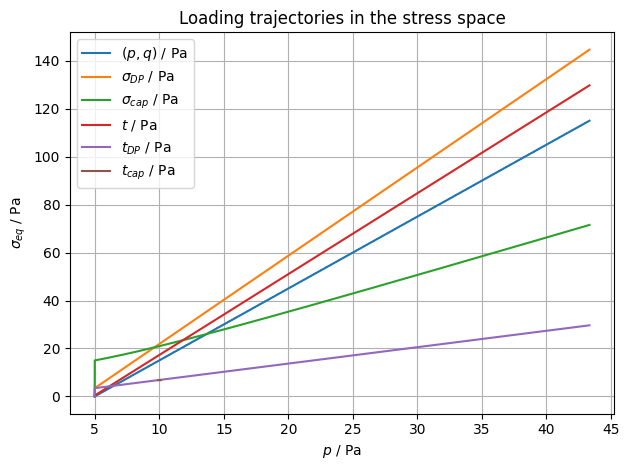

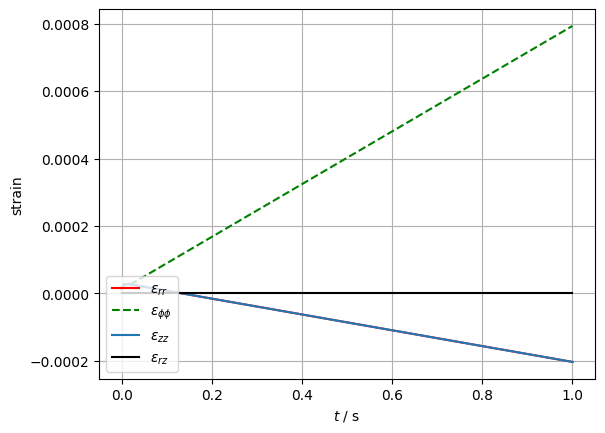

In [35]:
import os
import sys
sys.path.append("/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib/python3.11/site-packages")
import matplotlib.pyplot as plt
import numpy as np
import mtest

m = mtest.MTest()
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)
m.setMaximumNumberOfSubSteps(20)
m.setModellingHypothesis("Tridimensional")

model = "DruckerPragerCap"

controls = ["stress", "strain"]

# Set  material model implementation and path
lib_path = "/mofem_install/jupyter/thomas/mfront_interface/src/libBehaviour.so"
control = controls[0]

m.setBehaviour("generic", lib_path, model)

# Material constants

E = 150e3
nu = 0.3
d = 150
beta = 0.6
pa = -10
pb = -75

R = (pa - pb) / (d - pa * np.tan(beta))

# Loading programme
tMax = 1.0  # s , total time
nTime = 200
ltime = np.linspace(0.0, tMax, nTime)

p_con =  5 # confining pressure
p_axi = 120  

# Young's modulus: consistent initial value for the models

e_con = p_con * (1 - 2 * nu) / E
e_axi = 16 * e_con

# Environment parameters
m.setExternalStateVariable("Temperature", 293.15)

# Material parameters
# m.setMaterialProperty("YoungModulus", E)
# m.setMaterialProperty("PoissonRatio", nu)
m.setMaterialProperty("d", d)
m.setMaterialProperty("beta", beta)
m.setMaterialProperty("pa", pa)
m.setMaterialProperty("pb", pb)

# Set initial stress and strain state
eps_init = [e_con, e_con, e_con, 0.0, 0.0, 0.0]
sig_init = [p_con, p_con, p_con, 0.0, 0.0, 0.0]
m.setStress(sig_init)
m.setStrain(eps_init)

m.setImposedStress("SXX", {0: p_con, 0.02: p_con, 1.0: p_con})
m.setImposedStress("SYY", {0: p_con, 0.02: p_con, 1.0: p_con})

if control == "stress":
    m.setImposedStress("SZZ", {0: p_con, 0.02: p_con, 1.0: p_axi})
if control == "strain":
    raise NotImplementedError("Not implemented")


s = mtest.MTestCurrentState()
wk = mtest.MTestWorkSpace()
m.completeInitialisation()
m.initializeCurrentState(s)
m.initializeWorkSpace(wk)

# initialize output lists
pCurve = np.array([p_con])
qCurve = np.array([0.0])
eVCurve = np.array([0.0])
eQCurve = np.array([0.0])
strains = np.empty(shape=(4, nTime))
stresses = np.empty(shape=(4, nTime))
dpCurve = np.array([0.0])
capCurve = np.array([0.0])
tCurve = np.array([0.0])
tdpCurve = np.array([0.0])
ttCurve = np.array([0.0])
tcapCurve = np.array([0.0])

# stresses[0][:] = sig_init
for k in range(4):
    strains[k][0] = eps_init[k]

for k in range(4):
    stresses[k][0] = sig_init[k]

# initialize yield functions
nPoints = 1000
pRange = np.empty(shape=(nTime, nPoints))

# run sim
for i in range(nTime - 1):
    m.execute(s, wk, ltime[i], ltime[i + 1])
    # output variables:
    pressure = (s.s1[0] + s.s1[1] + s.s1[2]) / 3
    
    dev_stress = np.array([
        s.s1[0] - pressure,
        s.s1[1] - pressure,
        s.s1[2] - pressure,
        s.s1[3],  # s_xy
        s.s1[4],  # s_xz
        s.s1[5]   # s_yz
    ])
    
    vMstress = np.sqrt(
        0.5
        * (
            (s.s1[0] - s.s1[1]) ** 2
            + (s.s1[1] - s.s1[2]) ** 2
            + (s.s1[2] - s.s1[0]) ** 2
            + 3 * s.s1[3] ** 2
        )
    )
    epsilonV = s.e1[0] + s.e1[1] + s.e1[2]
    argument = (
        2
        * (
            s.e1[0] ** 2
            + s.e1[1] ** 2
            + s.e1[2] ** 2
            - epsilonV**2 / 3
            + 2 * s.e1[3] ** 2
        )
        / 3
    )
    vMstrain = np.sqrt(max(argument, 0))

    pCurve = np.append(pCurve, pressure)
    qCurve = np.append(qCurve, vMstress)
    eVCurve = np.append(eVCurve, epsilonV)
    eQCurve = np.append(eQCurve, vMstrain)
    
    # calculate for the stress surfaces? Don't quite understand
    
    J2 = (1/6) * (
        (s.s1[0] - s.s1[1]) ** 2 +
        (s.s1[1] - s.s1[2]) ** 2 +
        (s.s1[2] - s.s1[0]) ** 2
    ) + (s.s1[3] ** 2 + s.s1[4] ** 2 + s.s1[5] ** 2) / 3

    # Third invariant of deviatoric stress (r)
    S_dev = dev_stress[:3]  # Deviatoric normal stress components
    r = ((9/2) * np.dot(S_dev, S_dev)) ** (1/3)
    K = 0.8
    d = 0 # cohesion
    t = (vMstress / 2) * (
        1 + 1 / K - (1 - 1 / K) * ((r / vMstress) ** 3)
    )
    
    t_dp = pressure * np.tan(beta) + d
    
    tCurve = np.append(tCurve, t)
    tdpCurve = np.append(tdpCurve, t_dp)
    
    alpha = 0.03
    p_b = 100
    # pa = p_b - 
    
    def cap_surface(p, R, alpha, beta, d, p_a):
        # Calculate the term inside the square root
        sqrt_term = np.sqrt(np.maximum((R * (d + p_a * np.tan(beta)))**2 - (p - p_a)**2, 0))
        
        # Calculate the constant scaling term
        scale_factor = (1 + alpha - alpha / np.cos(beta)) / R
        
        # Calculate t based on the cap surface equation
        t = scale_factor * sqrt_term
        
        return t
    
    def transition_surface(p, R, alpha, beta, d, p_a):
        # Calculate the constant term for the transition surface
        constant_term = (1 - alpha / np.cos(beta)) * (d + p_a * np.tan(beta))
        
        # Calculate the second term (inside the square root)
        sqrt_term = np.sqrt((alpha * (d + p_a * np.tan(beta)))**2 - (p - p_a)**2)
        print((alpha * (d + p_a * np.tan(beta)))**2 - (p - p_a)**2)
        print(sqrt_term)
        # Calculate t based on the transition surface equation
        t = constant_term + sqrt_term
        return t
    tt = transition_surface(pressure,R,alpha,beta,d,p_a)
    tcap = cap_surface(pressure,R,alpha,beta,d,p_a)
    ttCurve = np.append(ttCurve, tt)
    tcapCurve = np.append(tcapCurve, tcap)
    
    
    sig_eq_dp = vMstress + np.tan(beta) * pressure
    sig_eq_cap = np.sqrt((pressure - pa)**2+(R*vMstress)**2)
    
    dpCurve = np.append(dpCurve, sig_eq_dp)
    capCurve = np.append(capCurve, sig_eq_cap)
    

    for k in range(4):
        strains[k][i + 1] = s.e1[k]

    for k in range(4):
        stresses[k][i + 1] = s.s1[k]

# print some final values
print(f"Triaxial test: Tridimensional")
print("final normal strain in z direction: ", s.e1[1])
print("final normal stress in z direction: ", s.s1[1], "Pa")
print("final von Mises stress: ", vMstress, "Pa")
print("final hydrostatic pressure: ", pressure, "Pa")

result_dir = f"/mofem_install/jupyter/thomas/mfront_interface/results/DP_sig_1_{p_axi}/"
os.makedirs(result_dir,exist_ok=True)

fig, ax = plt.subplots()
ax.set_title("Loading trajectories in the stress space")
print(tcapCurve)
ax.plot(pCurve, qCurve, label="$(p,q)$ / Pa")
ax.plot(pCurve, dpCurve, label="$\sigma_{DP}$ / Pa")
ax.plot(pCurve, capCurve, label="$\sigma_{cap}$ / Pa")
ax.plot(pCurve, tCurve, label="$t$ / Pa")
ax.plot(pCurve, tdpCurve, label="$t_{DP}$ / Pa")
ax.plot(pCurve, ttCurve, label="$t_{transition}$ / Pa")
ax.plot(pCurve, tcapCurve, label="$t_{cap}$ / Pa")
plt.quiver(
    pCurve[:-1],
    qCurve[:-1],
    pCurve[1:] - pCurve[:-1],
    qCurve[1:] - qCurve[:-1],
    scale_units="xy",
    angles="xy",
    scale=1,
)

ax.set_xlabel("$p$ / Pa")
ax.set_ylabel("$\sigma_{eq}$ / Pa")
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig(f"{result_dir}/Triaxial_YieldSurface.pdf")

fig, ax = plt.subplots()
ax.plot(ltime, strains[0][:], color="red", label=r"$\epsilon_{rr}$")
ax.plot(ltime, strains[2][:], "--", color="green", label=r"$\epsilon_{\phi\phi}$")
ax.plot(ltime, strains[1][:], label=r"$\epsilon_{zz}$")
ax.plot(ltime, strains[3][:], color="black", label=r"$\epsilon_{rz}$")
ax.set_xlabel("$t$ / s")
ax.set_ylabel("strain")
ax.grid()
ax.legend(loc="lower left")
fig.savefig(f"{result_dir}/Triaxial_Strains.pdf")


# fig, ax = plt.subplots()
# ax.plot(ltime, phiCurve - phi0, label=r"$\phi-\phi_0$")
# ax.plot(ltime, eVCurve, label=r"$\epsilon_{V}$")
# ax.plot(ltime, lpCurve, label=r"$\epsilon_{eq}$")
# ax.set_xlabel("$t$ / s")
# ax.set_ylabel(" ")
# ax.grid()
# ax.legend()

# plt.show()
